In [15]:
import numpy as np
from numpy import array

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import pymc3 as pm
import theano.tensor as tt
import arviz as az

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Data prep is key to a robust marketing mix model. We've prepped our data by grouping marketing spend and customer start activity by week, as is common practice, and standardizing all variables. 
**This scaling step is crucial as is allows us to leverage powerful statistical transforms like the beta, half-normal, and gamma distributions, which are critical to modeling the non-linear relationships present in our dataset.

In [32]:
df_in = pd.read_csv("TA_Marketing_Mix_Data.csv")

In [33]:
df_in["Date"] = pd.to_datetime(df_in["Date"])

In [45]:
y_obs = df_in.Starts.values

<Axes: >

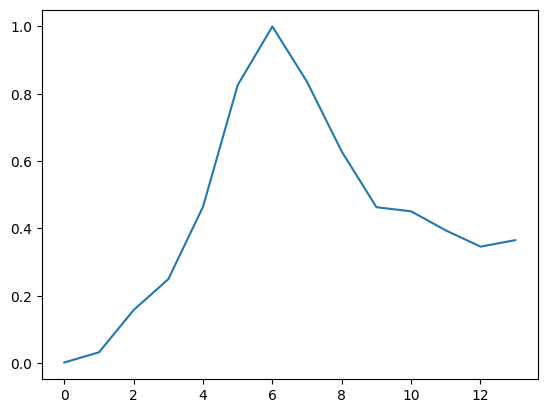

In [46]:
pd.Series(y_obs).plot() # customers acquired per week over the first four months of 2018

### Recommendations on order in which to apply adstock and saturation transformations
Option 1)<br>
For large sustained spend it makes sense to first apply the shape (saturation or diminishing return) effect and then apply the adstock function.<br>
Option 2)<br>
If there is small spend for any given time period, first apply the adstock transformation, then apply the saturation or diminishing return effect. This makes sense as the shape effect is likely not to be activated by small spend. 
<br>
<br>
**As observed spend with our dataset is fairly small, we first apply the adstock transformation and then our saturation effect.**

In [47]:
# marketing spend channels that commonly see a delayed impact
delay_channels = [
    'TV', 'Referral', 'DirectMail', 'TradeShows', 'SocialMedia','DisplayAds_Standard', 'ContentMarketing',
       'GoogleAds', 'SEO', 'Email', 'AffiliateMarketing',
]
# marketing spend channels that are less susceptible to adstock effects
non_lin_channels = ["DisplayAds_Programmatic"]
############################## geometric adstock function
def geometric_adstock_tt(
    x, alpha=0, L=12, normalize=True
):
    """
    The term "geometric" refers to the way weights are assigned to past values,
    which follows a geometric progression.
    In a geometric progression,
    each term is found by multiplying the previous term by a fixed, constant ratio (commonly denoted as "r").
    In the case of the geometric adstock function, the "alpha" parameter serves as this constant ratio.
    """
    w = tt.as_tensor_variable([tt.power(alpha, i) for i in range(L)])
    xx = tt.stack(
        [tt.concatenate([tt.zeros(i), x[: x.shape[0] - i]]) for i in range(L)]
    )

    if not normalize:
        y = tt.dot(w, xx)
    else:
        y = tt.dot(
            w / tt.sum(w), xx
        )  # dot product to get marketing channel over time frame of decay
    return y

### non-linear saturation function
def logistic_function(x_t, mu=0.1):
    """
    Models non-linear saturation effects and capture diminishing returns of marketing spend.
    """
    return (1 - np.exp(-mu * x_t)) / (1 * np.exp(-mu * x_t))


with pm.Model() as model:
    response_mean = []
    ################ ADSTOCK
    for channel_name in delay_channels:
        xx = df_in[channel_name].values
    
        print(f"Adding Delayed Channels: {channel_name}")
        channel_b = pm.HalfNormal(f"beta_{channel_name}", sd=5)
        alpha = pm.Beta(f"alpha_{channel_name}", alpha=3, beta=3)
        channel_mu = pm.Gamma(
            f"mu_{channel_name}", alpha=3, beta=1
        )
        
        response_mean.append(
            logistic_function(geometric_adstock_tt(xx, alpha), channel_mu) * channel_b
        )
    ################ SATURATION
    for channel_name in non_lin_channels:
        xx = df_in[channel_name].values
        
        print(f"Adding Non-Linear Logistic Channel: {channel_name}")
        channel_b = pm.HalfNormal(f"beta_{channel_name}", sd=5)
        channel_mu = pm.Gamma(
            f"mu_{channel_name}", alpha=3, beta=1
        )
        
        response_mean.append(logistic_function(xx, channel_mu) * channel_b)
    ################ LIKELIHOOD
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_hat = pm.Weibull("Y", alpha=3, beta=sum(response_mean), observed=y_obs)

Adding Delayed Channels: TV
Adding Delayed Channels: Referral
Adding Delayed Channels: DirectMail
Adding Delayed Channels: TradeShows
Adding Delayed Channels: SocialMedia
Adding Delayed Channels: DisplayAds_Standard
Adding Delayed Channels: ContentMarketing
Adding Delayed Channels: GoogleAds
Adding Delayed Channels: SEO
Adding Delayed Channels: Email
Adding Delayed Channels: AffiliateMarketing
Adding Non-Linear Logistic Channel: DisplayAds_Programmatic


The trace variable holds samples from the posterior distribution, sampled using the Markov Chain Monte Carlo (MCMC) method.

In [49]:
with model:
    trace = pm.sample(target_accept=0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_DisplayAds_Programmatic, beta_DisplayAds_Programmatic, mu_AffiliateMarketing, alpha_AffiliateMarketing, beta_AffiliateMarketing, mu_Email, alpha_Email, beta_Email, mu_SEO, alpha_SEO, beta_SEO, mu_GoogleAds, alpha_GoogleAds, beta_GoogleAds, mu_ContentMarketing, alpha_ContentMarketing, beta_ContentMarketing, mu_DisplayAds_Standard, alpha_DisplayAds_Standard, beta_DisplayAds_Standard, mu_SocialMedia, alpha_SocialMedia, beta_SocialMedia, mu_TradeShows, alpha_TradeShows, beta_TradeShows, mu_DirectMail, alpha_DirectMail, beta_DirectMail, mu_Referral, alpha_Referral, beta_Referral, mu_TV, alpha_TV, beta_TV]


/Users/erinoefelein/.local/share/virtualenvs/erinoefelein-xVuHf_Ws/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/erinoefelein/.local/share/virtualenvs/erinoefelein-xVuHf_Ws/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/erinoefelein/.local/share/virtualenvs/erinoefelein-xVuHf_Ws/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/erinoefelein/.local/share/virtualenvs/erinoefelein-xVuHf_Ws/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
There were 47 diverg

The plot_posterior method creates a plot consisting of multiple density plots, each of which show the overall shape of the posterior distribution for each variable. The posterior distribution shows the range of possible values for a parameter or variable after considering the data and prior information.

Each density plot helps visualize the uncertainty present in model parameters. Adjusting the HDI allows us to focus on the most probable region of the posterior distribution, representing the most credible ranges of values for the parameters. An HDI less than 1 excludes less probable tails of the distribution that might be more uncertain or influenced by outliers. The posterior mean serves as a summary statistic and is included with each plot. 

Got error No model on context stack. trying to find log_likelihood in translation.


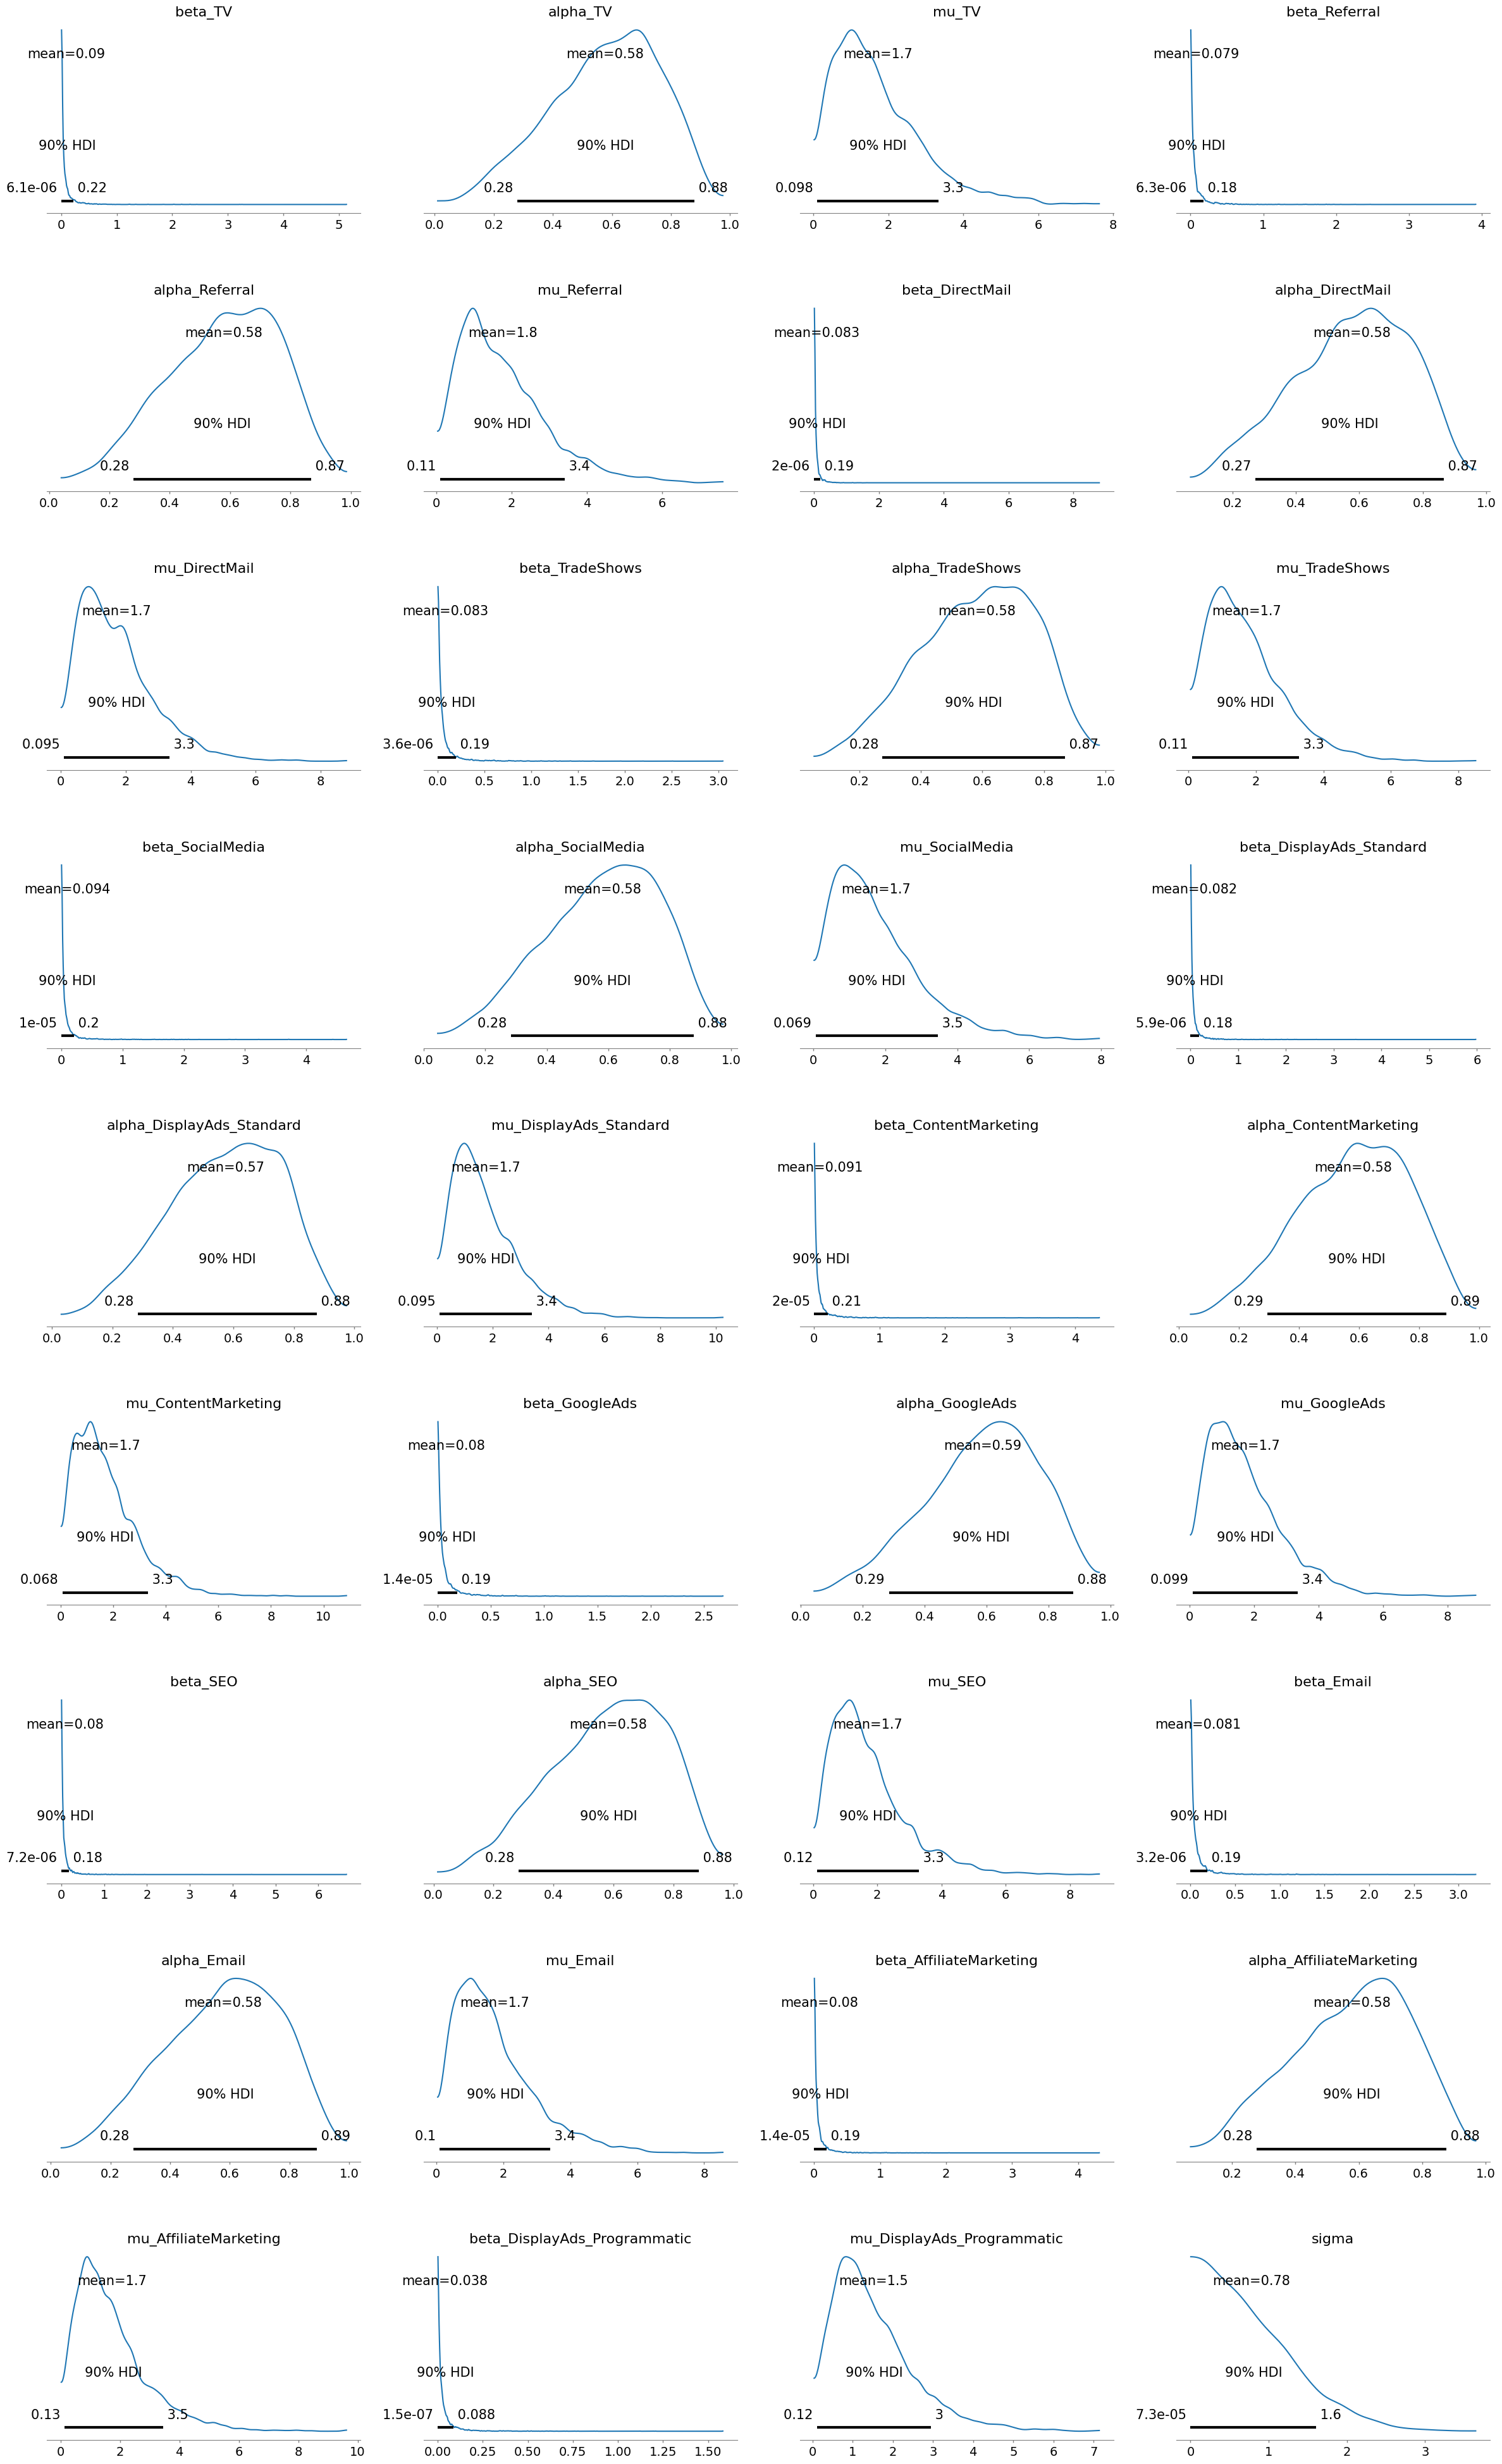

In [63]:
az.plot_posterior(trace, hdi_prob=0.9)
plt.subplots_adjust(hspace=0.45)

In [51]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

It is typical to check model performance by conducting a posterior predictive check (PPC). Data are simulated from the fitted model and stored to the ppc variable. In other words, the **ppc** variable contains samples drawn from the posterior predictive distribution. These samples represent values that could have been generated by the model.<br>
<br>
Using the **ppc** variable, we create a plot to assess the model's posterior predictive distribution fit to the actual data. This plot serves as a tool for evaluating model fit and aids in identifying any potential issues.<br>

**Interpreting the Plot:**<br>
*A Good Fit:* The model effectively captures the characteristics of the data if the observed data closely follows the trajectory of the posterior predictive mean.<br>
*A Poor Fit:* Conversely, significant deviations between the observed data and the posterior predictive mean suggest potential challenges in the model's ability to represent underlying patterns in the data.
<br>
Keep in mind that the posterior predictive mean is just one way to summarize the posterior predictive distribution! In some cases, other summaries, such as the median or quantiles, may be more informative.

<Axes: xlabel='Y / Y'>

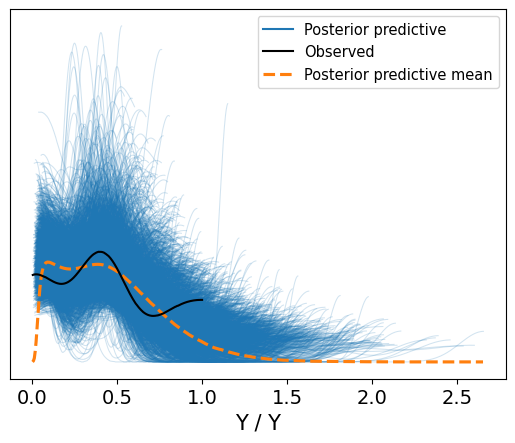

In [52]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

# Summary Metrics
**mean:** The posterior mean, a central estimate of each parameter's value.<br>
**sd:** The posterior standard deviation, reflecting uncertainty around the mean.<br>
**hdi_3%:** The lower bound of the 90% Highest Density Interval (HDI), indicating the 3rd percentile of the posterior distribution.<br>
**hdi_97%:** The upper bound of the 90% HDI, indicating the 97th percentile.<br>
**mcse_mean:** Monte Carlo Standard Error (MCSE) for the mean, a measure of sampling error.<br>
**mcse_sd:** MCSE for the standard deviation.<br>
**ess_bulk:** Effective Sample Size (ESS) for the bulk of the distribution, reflecting how many independent samples contribute to the central part of the posterior.<br>
**ess_tail:** ESS for the tails of the distribution, indicating how well the tails are estimated.<br>
**r_hat:** Potential Scale Reduction Factor (PSRF), measuring convergence of Markov chains (values close to 1.0 suggest convergence).<br>

In [65]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_TV,0.090,0.203,0.000,0.315,0.004,0.003,2361.0,2125.0,1.0
alpha_TV,0.577,0.186,0.222,0.890,0.003,0.002,3601.0,1935.0,1.0
mu_TV,1.709,1.187,0.048,3.837,0.023,0.017,2238.0,1672.0,1.0
beta_Referral,0.079,0.173,0.000,0.259,0.004,0.002,2457.0,1858.0,1.0
alpha_Referral,0.579,0.184,0.218,0.880,0.003,0.002,3186.0,2166.0,1.0
mu_Referral,1.760,1.169,0.115,3.961,0.021,0.015,2887.0,2445.0,1.0
beta_DirectMail,0.083,0.220,0.000,0.278,0.006,0.004,1737.0,1373.0,1.0
alpha_DirectMail,0.575,0.184,0.238,0.896,0.004,0.002,2825.0,2236.0,1.0
mu_DirectMail,1.714,1.151,0.049,3.795,0.023,0.016,2045.0,1623.0,1.0
beta_TradeShows,0.083,0.169,0.000,0.281,0.005,0.003,2050.0,1992.0,1.0


When accessible, we could additionally incorporate internal and competitor pricing to the model as continuous control variables. Our final output would then be a model consisting of a linear combination of baseline conversions, the spend in the marketing channels, and the impact of any control variables.